# Example 1

This notebook will give a quick example on how to download and process Kik-Net downhole array motions.

In [1]:
import datools

### Step 0: Access Kik-Net's website and download your motions

Here is a video outlining how you can do this: https://www.youtube.com/watch?v=zvhaZqRpw3w

### Step 1: Format Compressed Kik-Net Files into Something Useable in Python

When downloading data from Kik-Net, the file structure is as follows:



<pre style="font-family: monospace; font-size: 0.9rem;">
big_dataset.tar
├── site_001.tar
│   ├── event_001/
│   │   ├── channel_01.EW1
│   │   ├── channel_02.EW2
│   │   ├── channel_03.NS1
│   │   ├── channel_04.NS2
│   │   ├── channel_05.UD1
│   │   └── channel_06.UD2
│   └── … (etc.)
└── site_nnn.tar
    └── … (etc.)
</pre>

Simply use the function `grabASCIIs(input_directory, output_directory)`, which unpacks the ASCII/ground motion files, and organizes them by site code:

<pre style="font-family: monospace; font-size: 0.9rem;">

├── site_001
│   ├── channel_01.EW1
│   ├── channel_02.EW2
│   ├── channel_03.NS1
│   ├── channel_04.NS2
│   ├── channel_05.UD1
│   ├── channel_06.UD2
│   ├── channel_01.EW1
│   └── channel_nn.nn
└── site_nnn
    ├── channel_01.EW1
    └── … (etc.)
</pre>

Each ground motion on Kik-Net takes the form of an ASCII file (full documentation on the file details are available [here]( www.kyoshin.bosai.go.jp/kyoshin/man/knetform_en.html)).  
  
Each event is comprised of six channels, three for both the surface and base seismographs (Table 1). 


<center>

**Table 1:** Kik-Net Site-Component Breakdown
| Channel number | Component | Location  | Extension of file |
|----------------|-----------|-----------|-------------------|
| 1              | NS        | Borehole  | NS1               |
| 2              | EW        | Borehole  | EW1               |
| 3              | UD        | Borehole  | UD1               |
| 4              | NS        | Surface   | NS2               |
| 5              | EW        | Surface   | EW2               |
| 6              | UD        | Surface   | UD2               |

</center>

In [2]:

datools.signal_processing.grabASCIIs(tarfile_path = "data/Example_1/example_kik.tar" , exdir="data/Example_1/example_kik")


### Step 2: Construct a Stream from Directory

For data processing, this package uses Obspy Stream objects.
Streams are list-like objects which contain multiple Trace objects, i.e. gap-less continuous time series and related header/meta information.  
  
Full documentation for Obspy Stream objects can be found [here](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream).

In [3]:
st = datools.signal_processing.genstream("data/Example_1/example_kik","EW2")

### Step 3: Linear Detrend and Demean

Attempting to remove bias: the code subtracts the mean (average) of the data from each individual data point first. It then removes a straight line fit from each point in the data.

$$
\text{Demeaned } x_i = x_i - \bar{x}, \quad \text{where } \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

$$
\text{Detrended } y_i = y_i - \hat{y}_i, \quad \text{where } \hat{y}_i = a + b t_i
$$

In [4]:
st = datools.signal_processing.detrend_demean(st)

### Step 3.1: Plot Streams

For this example, three different ground motions from three different sites are plotted.  

Only the East-West channel data from the surface seismograph is considered; in Kik-Net notation, these files are described as "FileName".EW2

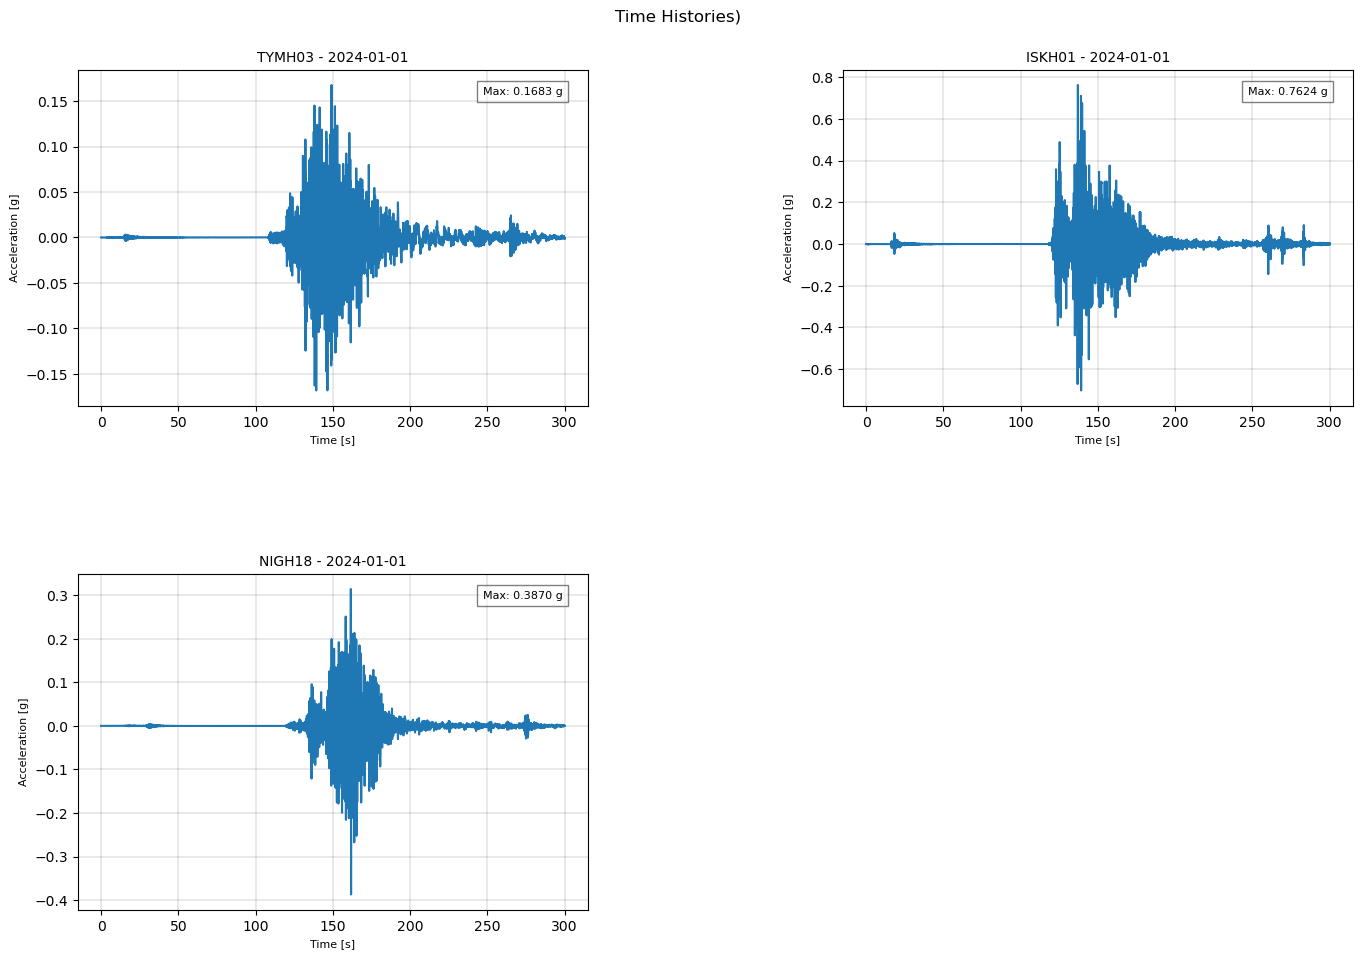

In [5]:
datools.signal_processing.plotstream(st)

### Step 4: Trim motions

This code uses the Recursive STA/LTA algorithm to find an estimate for the beginning of the signal. [Source](https://gfzpublic.gfz-potsdam.de/rest/items/item_4097/component/file_4098/content).

After finding the beginning of the signal, one can then decide to trim the time series around said signal. One can designate how many seconds of data that would be desired before and after the signal trigger. If the signal trigger time looks a bit off, manually adjust this.

**NOTE:** The following code finds a time 25s before the trigger (i.e., signal arrival estimate). In other words, one gets 25 seconds of noise.

/Users/griffinberse/Documents/datools/src/datools/signal_processing.py:230: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trace_data = pd.concat([trace_data, new_row], ignore_index=True)


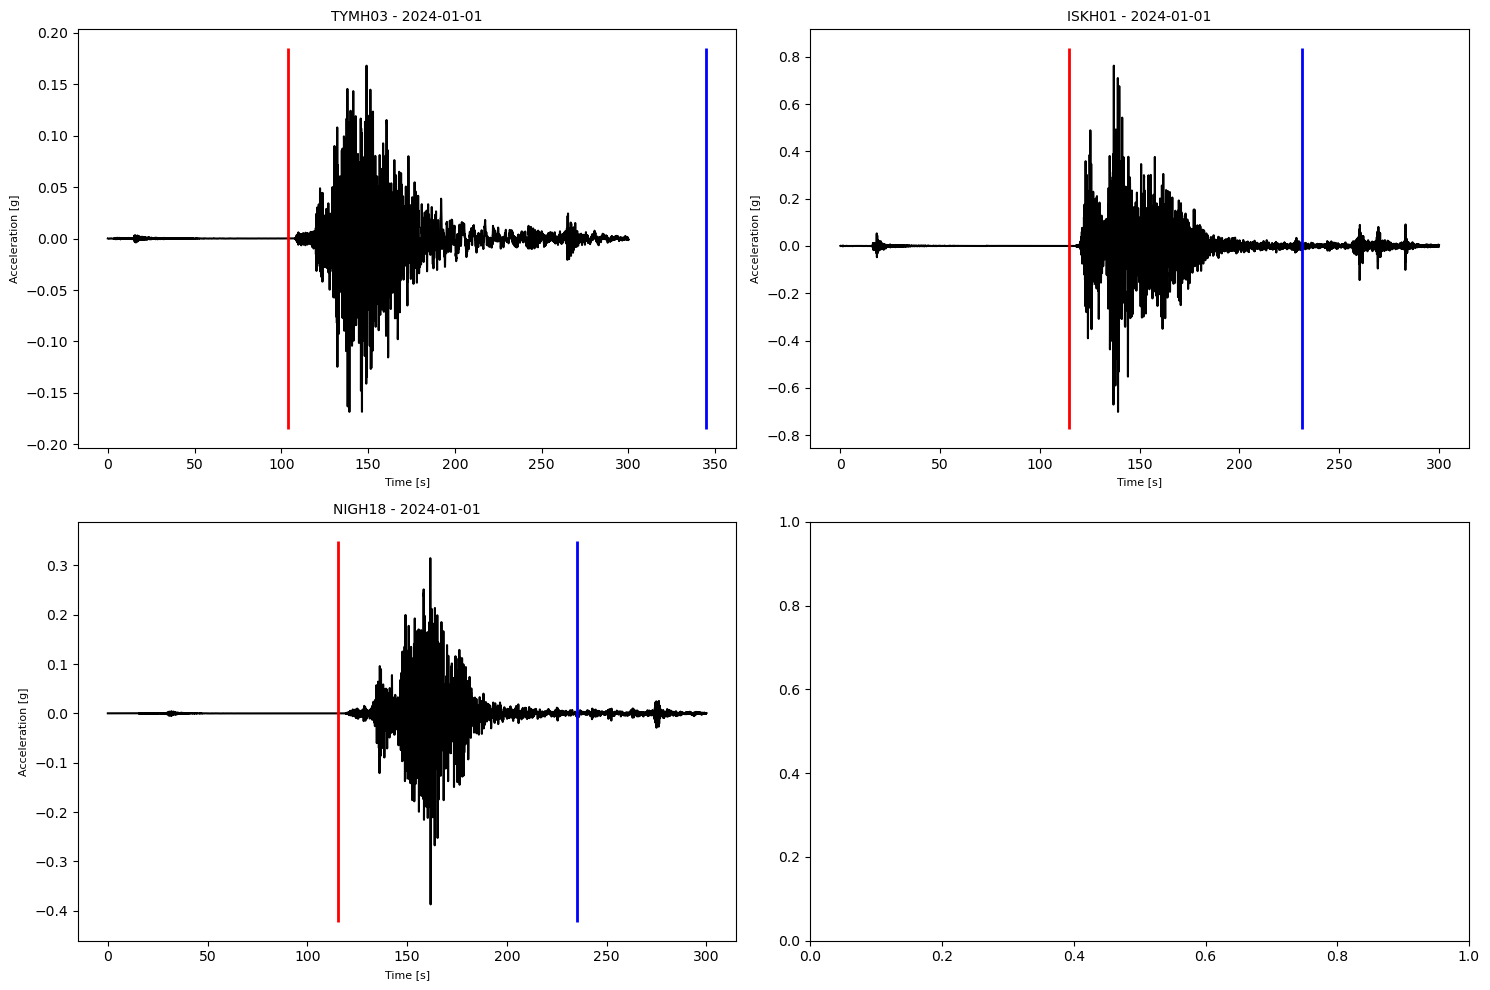

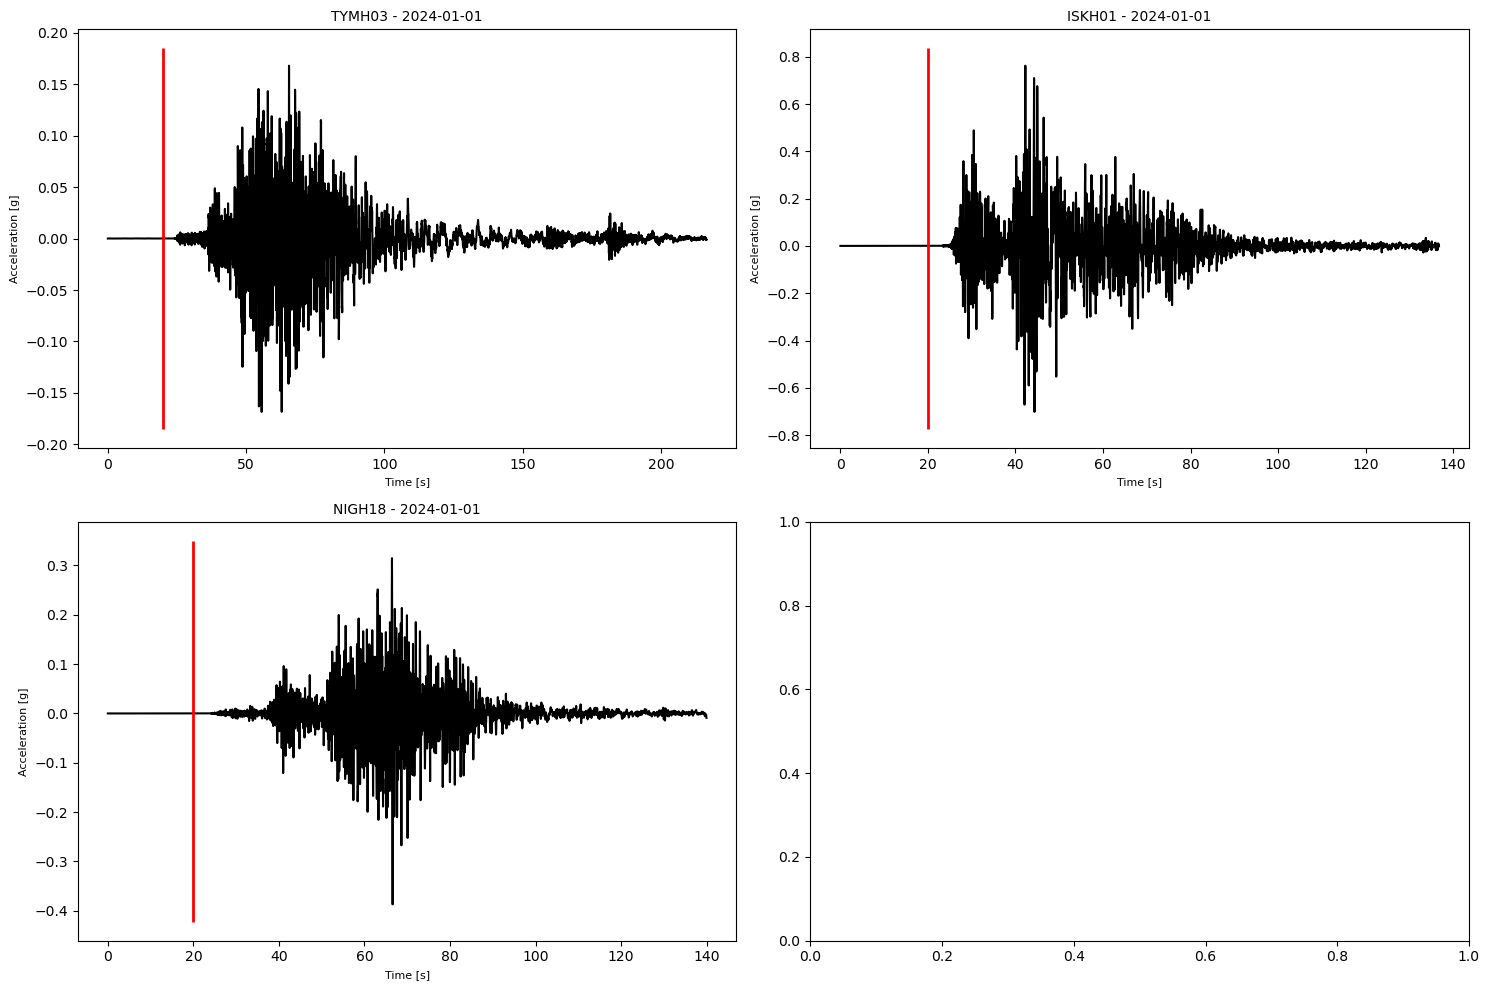

No traces without triggers to display.


In [6]:
new_st, trigger_data, no_trigger_stream = datools.signal_processing.narrowstream(st, before=25, after=45, trigger_adjusted=5)

### Step 5: Calculate the Signal to Noise Ratio (SNR)

The following function simply calculates the first and last points where the motion (in the frequency domain) has a SNR that is < 3.  
**No Filtering** is done yet. This simply finds and stores the frequencies in a pandas DataFrame.

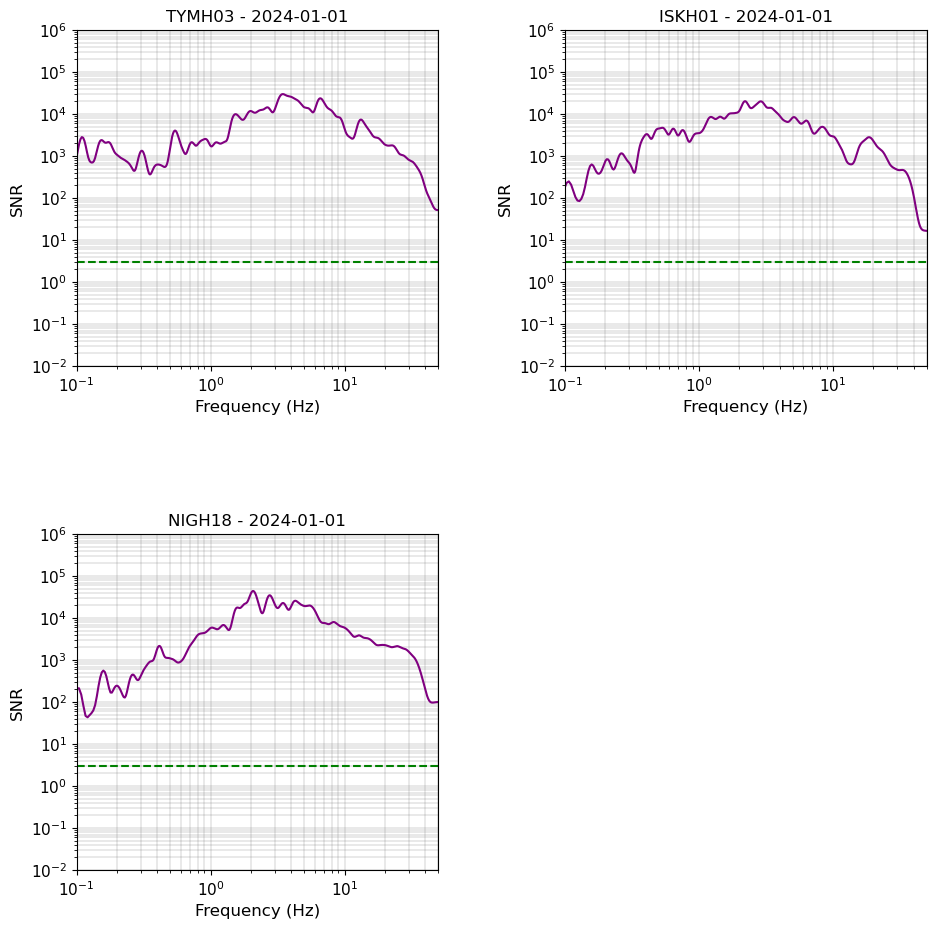

In [7]:
SNR_corner_freq = datools.signal_processing.snr(new_st, trigger_data)

These are relatively large motions ---> high SNR ratios. At no point is there a SNR < 3.

### Step 6: Calculate Low and High Pass Frequency Bounds for Buttersworth Filter

When referring to the term filter frequencies or filter bounds, the high and low pass points for a Bandpass (e.g. a Buttersworth filter) are being discussed. The SNR filter-frequency method is only one way to find filter frequencies.   

One must not have a low-pass filter applied after the Nyquist frequency (needed for anti-aliasing).  

Additionally, there are other possible options to determine a possible high-pass frequency, including the "UCLA" method outlined by Ramos-Sepulveda et. al (2023):  
https://ascelibrary.org/doi/epdf/10.1061/9780784484692.034 (Ramos-Sepulveda 2023)

In [8]:
frequency_window = datools.signal_processing.corner_freq(new_st,SNR_corner_freq,0.0001)

/Users/griffinberse/Documents/datools/src/datools/signal_processing.py:739: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  window = window.fillna(value=np.nan)


The code above once again **Does Not** filter the waveform just yet, but rather finds the Nyquist and "UCLA" filter frequencies and combines them into a DataFrame (example below).  
  
Included in this DataFrame are the recommended low and high pass filter frequencies. These recomendations are built on the the most conservative frequency range. For example, the high-pass is whichever frequency is higher, comparing the SNR and "UCLA" method. The low-pass is whichever frequency is lower, comparing the Nyquist and SNR frequencies.

In [9]:
frequency_window

,Site ID,Date,Trace Number,SNR=3 Frequencies (upper),SNR=3 Frequencies,SNR < 1,SNR < 3,UniqueID,UCLAhf,lf,corner_filter_frequency_hp,corner_filter_frequency_lp
0,TYMH03,2024-01-01T07:10:00.610000Z,1,NaN,0.000,No,Yes,TYMH032401011610.EW2,0.044452,40.0,0.044452,40.0
1,ISKH01,2024-01-01T07:09:46.790000Z,2,NaN,0.015,No,Yes,ISKH012401011610.EW2,0.032349,40.0,0.032349,40.0
2,NIGH18,2024-01-01T07:10:05.170000Z,3,NaN,0.000,No,Yes,NIGH182401011610.EW2,0.122050,40.0,0.122050,40.0


### Step 7: Apply Bandpass

The following code actually applies the buttersworth bandpass on the ground motions. Recommended corners for the bandpass have a degree of 4. This recommendation is taken from [Bahmpouri (2020)](https://journals.sagepub.com/doi/full/10.1177/8755293020952447)

In [10]:
filtered_st = datools.signal_processing.buttersworth(new_st, frequency_window,c=4)

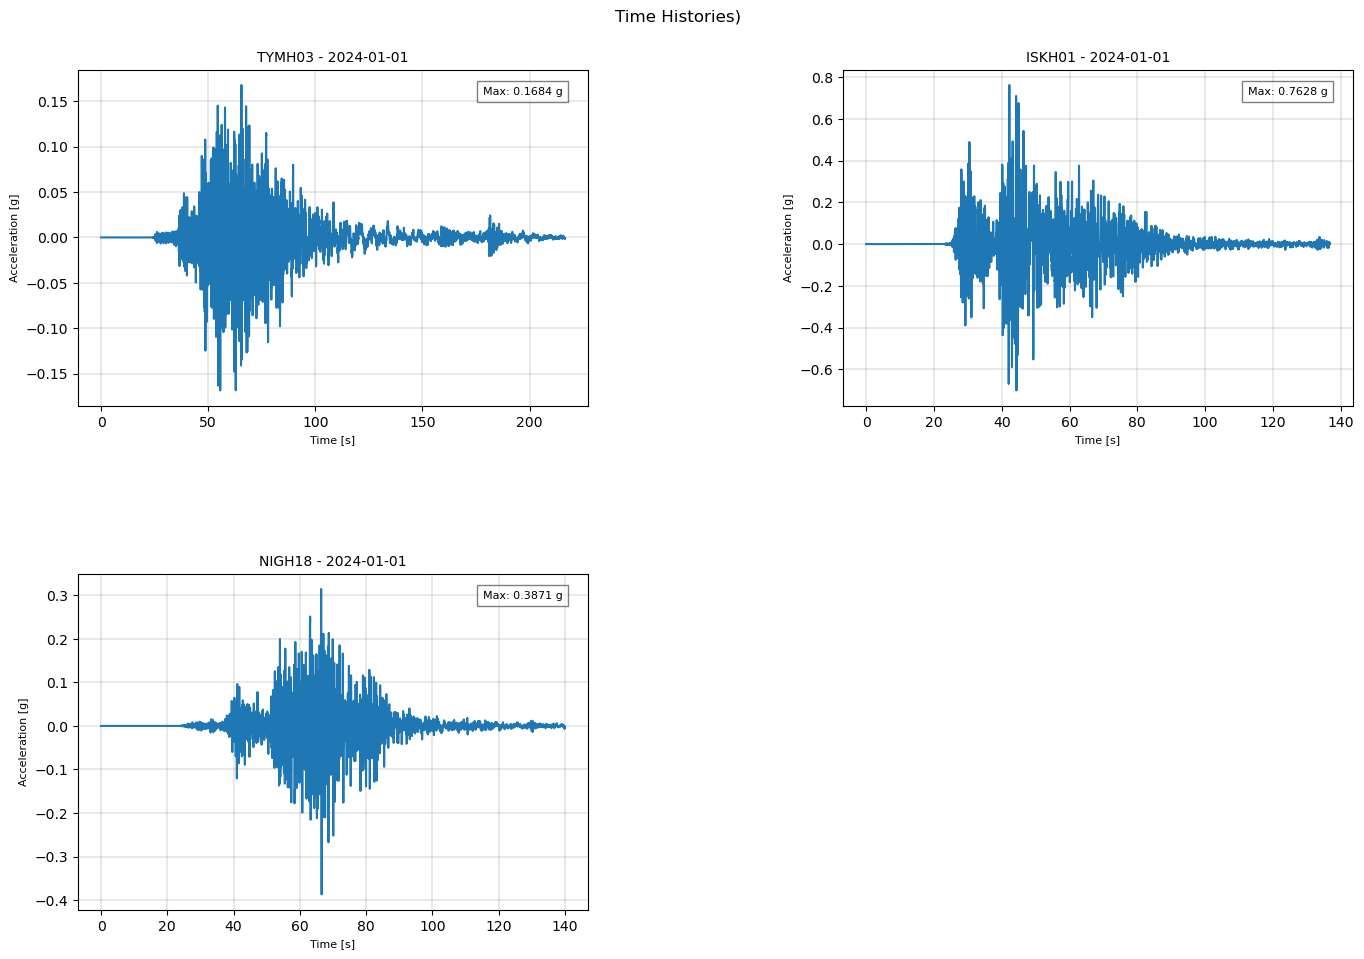

In [11]:
datools.signal_processing.plotstream(filtered_st)

### Step 8: Save filtered data

The processed data can be saved into several different types of file types. The default is .MSEED.

In [ ]:
datools.signal_processing.save_seismic_data(filtered_st,base_path="data/Example_1",
                                            station_code="EW2",
                                            dir_prefix = 'processed_sample_data'
                                            )

Saved data for station EW2 in 1 format(s) to:
  data/EW2/processed_sample_dataEW2
